Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Install Required Packages

In [2]:
!pip install opencv-python torch torchvision pandas


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 107.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 91.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

Set Up Logging

In [3]:
import torch
import cv2
from pathlib import Path
import pandas as pd
import os
import logging

# Set up logging
logging.basicConfig(filename='detection.log', level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')

def setup_logging():
    logging.info('🚀 Starting object detection process.')

def log_info(message):
    logging.info(f'ℹ️ {message}')

def log_error(error):
    logging.error(f'❌ {error}')

setup_logging()


Verify Image Directory

In [10]:
import os
from pathlib import Path

# Verify image directory
image_dir = '/content/drive/My Drive/photos'
if not os.path.exists(image_dir):
    print(f"Image directory not found: {image_dir}")
else:
    images = list(Path(image_dir).glob('*.jpg'))
    if not images:
        print(f"No images found in the directory: {image_dir}")
    else:
        print(f"Found {len(images)} images in the directory: {image_dir}")


Found 1455 images in the directory: /content/drive/My Drive/photos


Define Object Detection Function

In [34]:
def detect_objects(model, image_dir, save_dir, csv_file):
    log_info('Performing object detection...')

    # Create the save directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)

    images = list(Path(image_dir).glob('*.jpg'))
    data = []
    no_detections = []

    if not images:
        log_error('No images found in the specified directory.')
        return

    # Set model confidence threshold
    model.conf = 0.1  # Set confidence threshold to 0.1

    for img_path in images:
        log_info(f'Processing image: {img_path}')
        img = cv2.imread(str(img_path))
        if img is None:
            log_error(f'Failed to read image: {img_path}')
            continue

        try:
            results = model(img)
            if results.xyxy[0].shape[0] == 0:
                log_error(f'No detections for image: {img_path.name}')
                no_detections.append(img_path.name)
                continue

            img_with_boxes = results.render()[0]  # Render and get the first image with boxes drawn
            output_path = os.path.join(save_dir, img_path.name)
            cv2.imwrite(output_path, img_with_boxes)

            log_info(f'Detection results for {img_path.name}: {results.xyxy[0]}')

            for det in results.xyxy[0]:
                x1, y1, x2, y2, conf, cls = det
                width = x2 - x1
                height = y2 - y1
                x_center = x1 + width / 2
                y_center = y1 + height / 2
                data.append({
                    'file_name': img_path.name,
                    'class_id': int(cls.item()),
                    'x_center': x_center.item(),
                    'y_center': y_center.item(),
                    'width': width.item(),
                    'height': height.item(),
                    'confidence': conf.item()
                })
        except Exception as e:
            log_error(f'Error processing image {img_path.name}: {e}')

    if data:
        # Convert list of dictionaries to DataFrame and save to CSV
        df = pd.DataFrame(data)
        df.to_csv(csv_file, index=False)
        log_info(f'Object detection completed and results saved to {csv_file}.')
    else:
        log_error('No data was extracted from object detection.')

    # Save filenames of images without detections
    no_detections_file = 'no_detections.txt'
    with open(no_detections_file, 'w') as f:
        for item in no_detections:
            f.write(f"{item}\n")
    log_info(f'List of images without detections saved to {no_detections_file}.')

# Define the paths
image_dir = '/content/drive/My Drive/photos'
save_dir = 'photo_results/images'
csv_file = 'detection_results.csv'

# Perform object detection
try:
    setup_logging()
    model = load_yolo_model()
    detect_objects(model, image_dir, save_dir, csv_file)
    log_info('✅ Object detection process completed successfully.')
except Exception as e:
    log_error(f'Error during object detection: {e}')


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2025-2-1 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
ERROR:root:❌ No detections for image: @lobelia4cosmetics_14703.jpg
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
ERROR:root:❌ No detections for image: @lobelia4cosmetics_14702.jpg
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch

Check and Display Results

Files in save directory: ['@lobelia4cosmetics_15092.jpg', '@lobelia4cosmetics_14665.jpg', '@lobelia4cosmetics_14967.jpg', '@lobelia4cosmetics_14693.jpg', '@lobelia4cosmetics_13872.jpg', '@lobelia4cosmetics_15073.jpg', '@lobelia4cosmetics_14352.jpg', '@lobelia4cosmetics_14032.jpg', '@lobelia4cosmetics_14701.jpg', '@lobelia4cosmetics_15150.jpg', '@lobelia4cosmetics_13751.jpg', '@lobelia4cosmetics_14197.jpg', '@lobelia4cosmetics_14881.jpg', '@lobelia4cosmetics_14029.jpg', '@lobelia4cosmetics_15011.jpg', '@lobelia4cosmetics_14181.jpg', '@lobelia4cosmetics_14784.jpg', '@lobelia4cosmetics_13773.jpg', '@lobelia4cosmetics_14155.jpg', '@lobelia4cosmetics_14231.jpg', '@lobelia4cosmetics_14421.jpg', '@lobelia4cosmetics_14068.jpg', '@lobelia4cosmetics_14255.jpg', '@lobelia4cosmetics_14890.jpg', '@lobelia4cosmetics_14290.jpg', '@lobelia4cosmetics_14347.jpg', '@lobelia4cosmetics_14489.jpg', '@lobelia4cosmetics_15100.jpg', '@lobelia4cosmetics_14830.jpg', '@lobelia4cosmetics_14801.jpg', '@lobelia4cosm

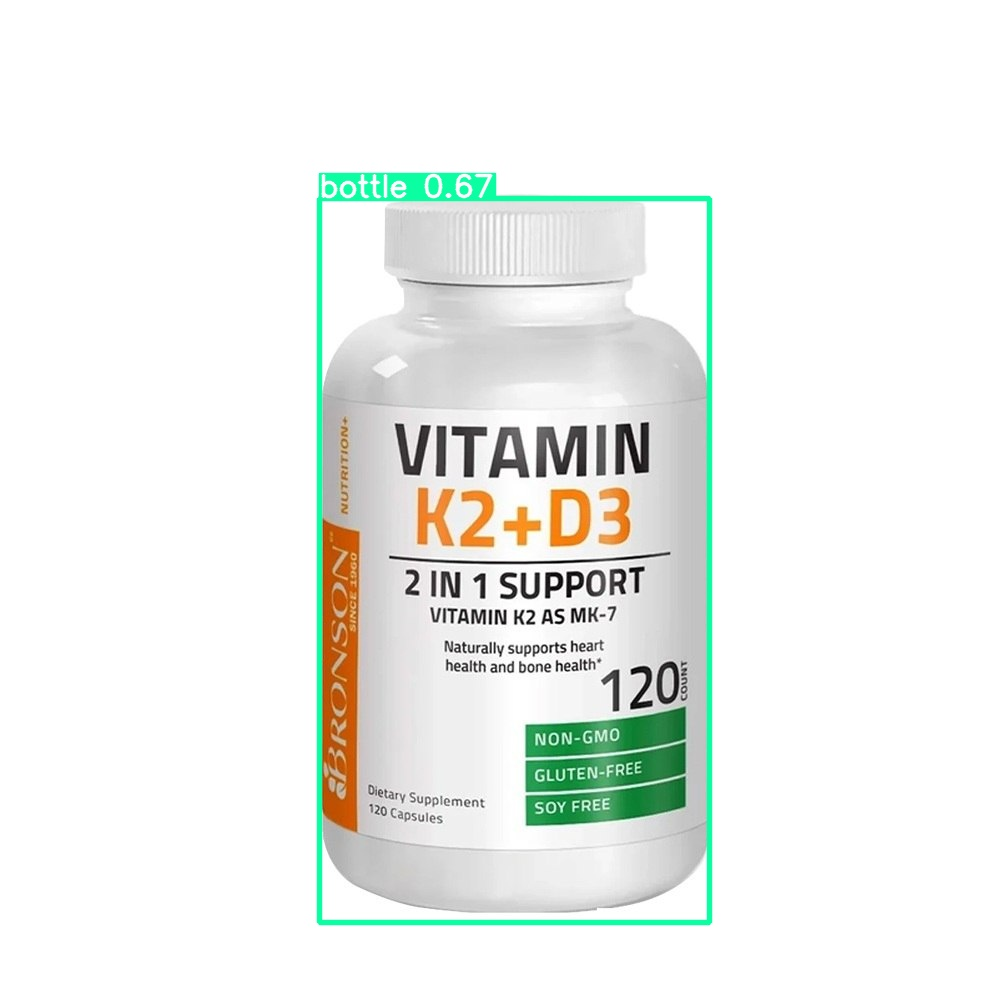

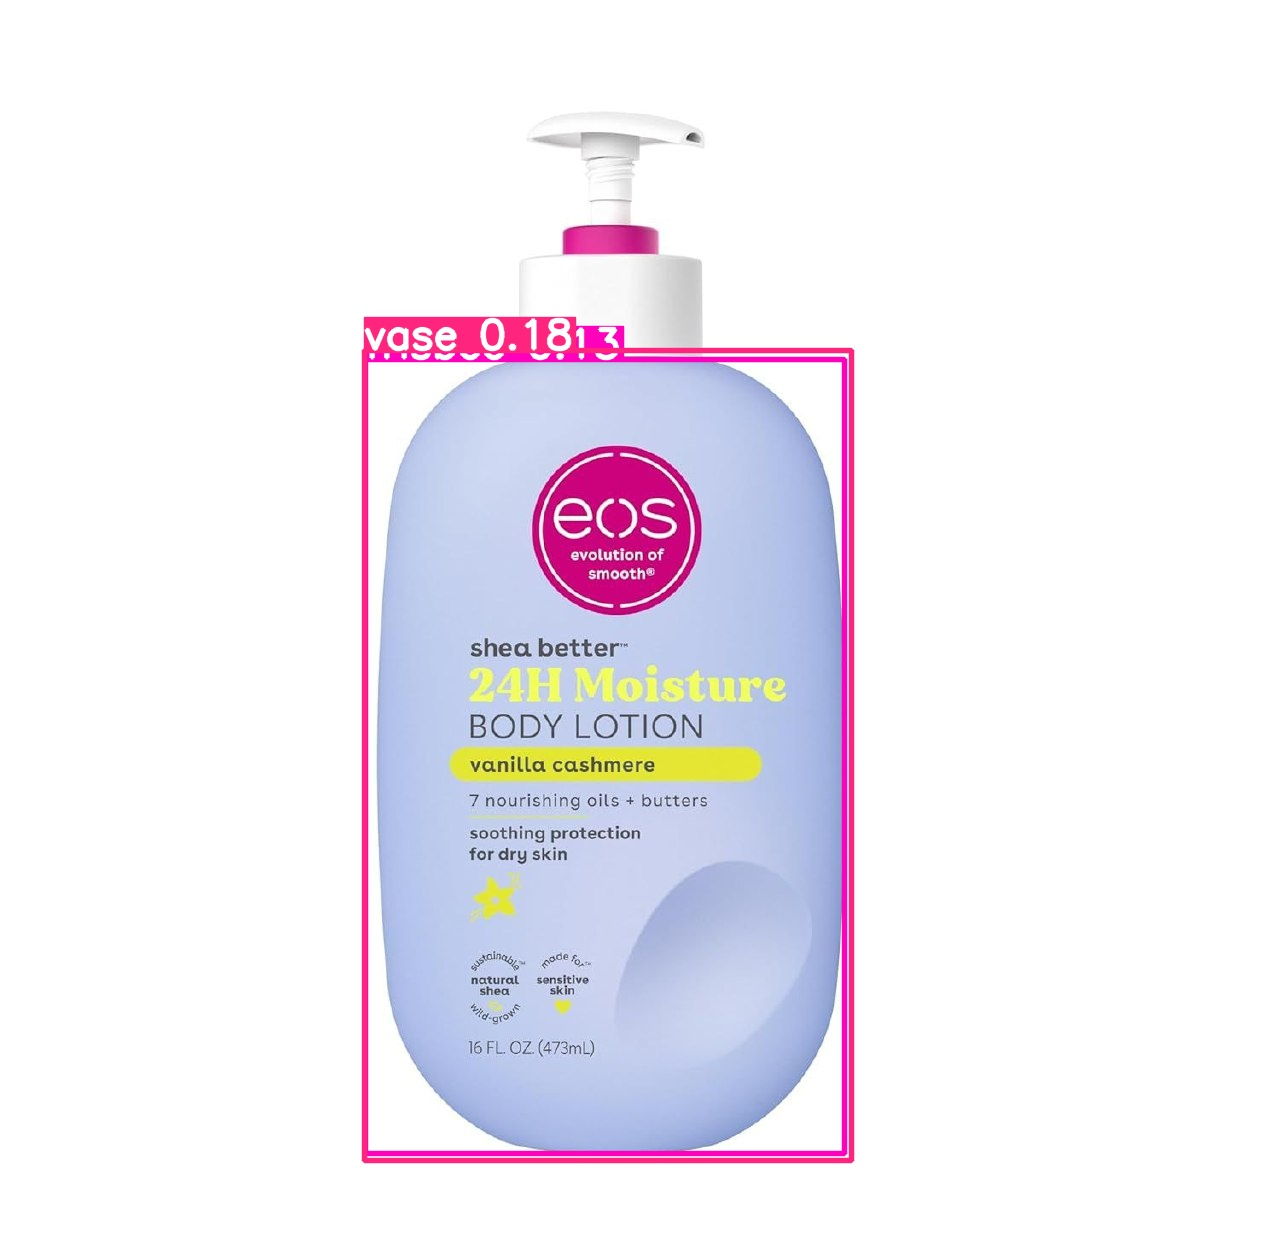

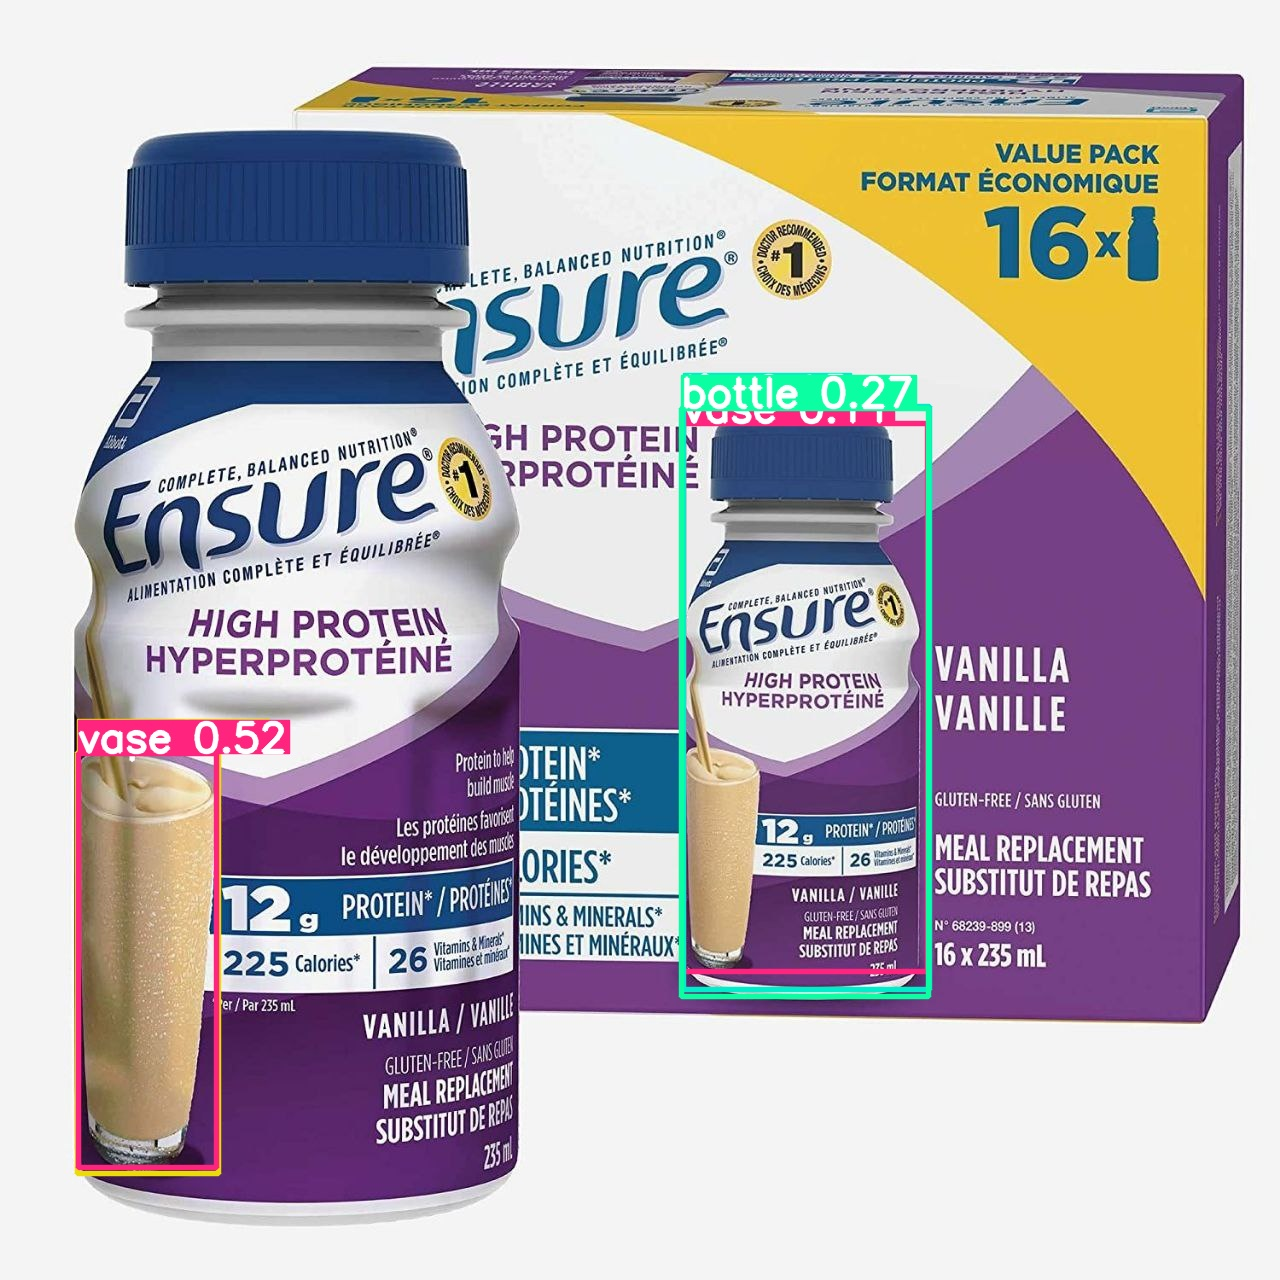

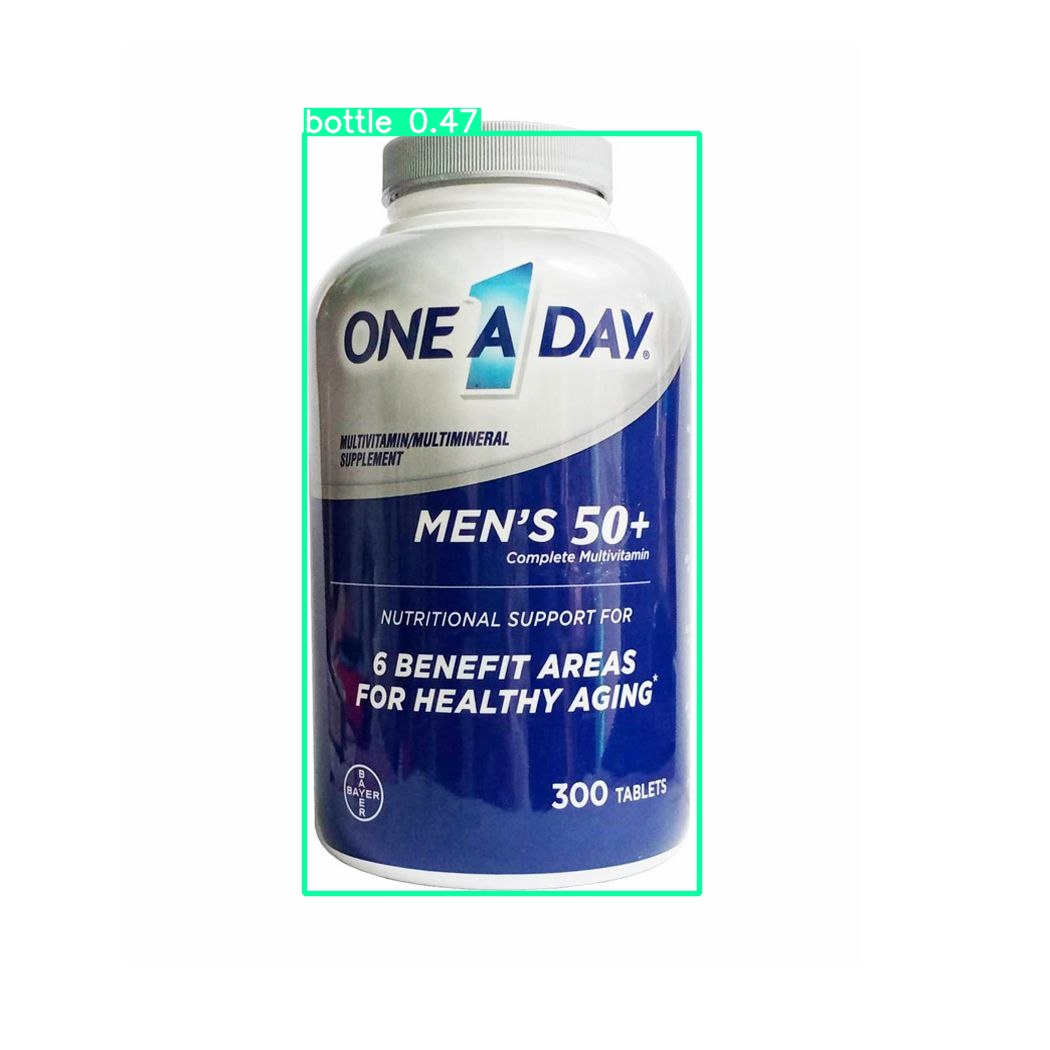

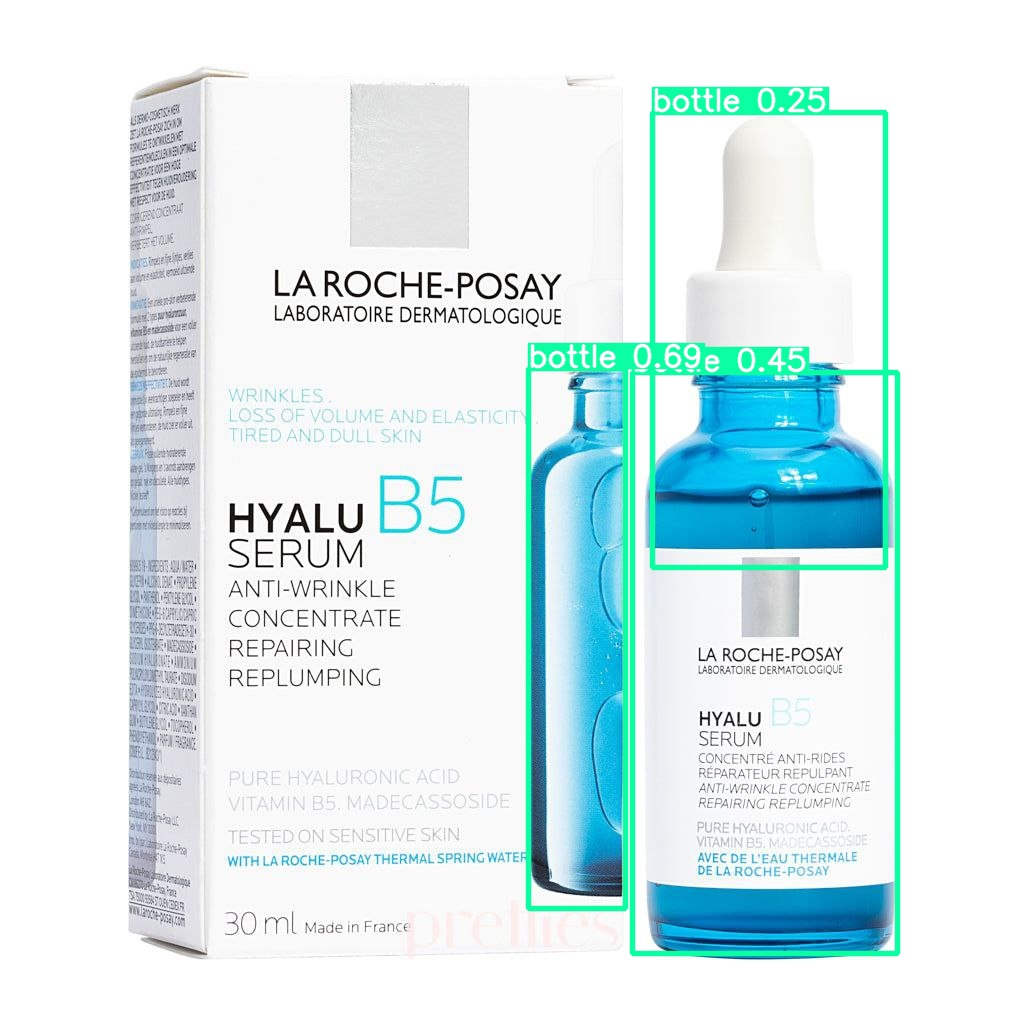

In [35]:
from IPython.display import Image, display
import os
import pandas as pd

# Define the save directory and CSV file path
save_dir = 'results/images'
csv_file = 'detection_results.csv'

# Check the contents of the save directory
if os.path.exists(save_dir):
    files = os.listdir(save_dir)
    print("Files in save directory:", files)
else:
    print("Save directory not found")

# Check the contents of the CSV file
if os.path.exists(csv_file):
    df = pd.read_csv(csv_file)
    num_rows, num_cols = df.shape
    print(f"The CSV file has {num_rows} rows and {num_cols} columns.")
    print("CSV file contents:")
    print(df.head())
else:
    print("CSV file not found or is empty")

# Display the first few annotated images
if os.path.exists(save_dir):
    files = os.listdir(save_dir)
    for filename in files[:5]:  # Display the first 5 images
        if filename.endswith(".jpg"):
            display(Image(os.path.join(save_dir, filename)))
else:
    print("Save directory not found")


Files in save directory: ['@lobelia4cosmetics_15092.jpg', '@lobelia4cosmetics_14081.jpg', '@lobelia4cosmetics_14665.jpg', '@lobelia4cosmetics_14967.jpg', '@lobelia4cosmetics_14281.jpg', '@lobelia4cosmetics_14951.jpg', '@lobelia4cosmetics_14432.jpg', '@lobelia4cosmetics_14693.jpg', '@lobelia4cosmetics_13872.jpg', '@lobelia4cosmetics_14279.jpg', '@lobelia4cosmetics_14857.jpg', '@lobelia4cosmetics_14656.jpg', '@lobelia4cosmetics_15073.jpg', '@lobelia4cosmetics_14352.jpg', '@lobelia4cosmetics_14032.jpg', '@lobelia4cosmetics_14093.jpg', '@lobelia4cosmetics_14701.jpg', '@lobelia4cosmetics_15150.jpg', '@lobelia4cosmetics_13751.jpg', '@lobelia4cosmetics_14197.jpg', '@lobelia4cosmetics_15044.jpg', '@lobelia4cosmetics_14881.jpg', '@lobelia4cosmetics_13911.jpg', '@lobelia4cosmetics_14029.jpg', '@lobelia4cosmetics_15011.jpg', '@lobelia4cosmetics_14181.jpg', '@lobelia4cosmetics_14784.jpg', '@lobelia4cosmetics_13773.jpg', '@lobelia4cosmetics_14163.jpg', '@lobelia4cosmetics_14155.jpg', '@lobelia4cosm

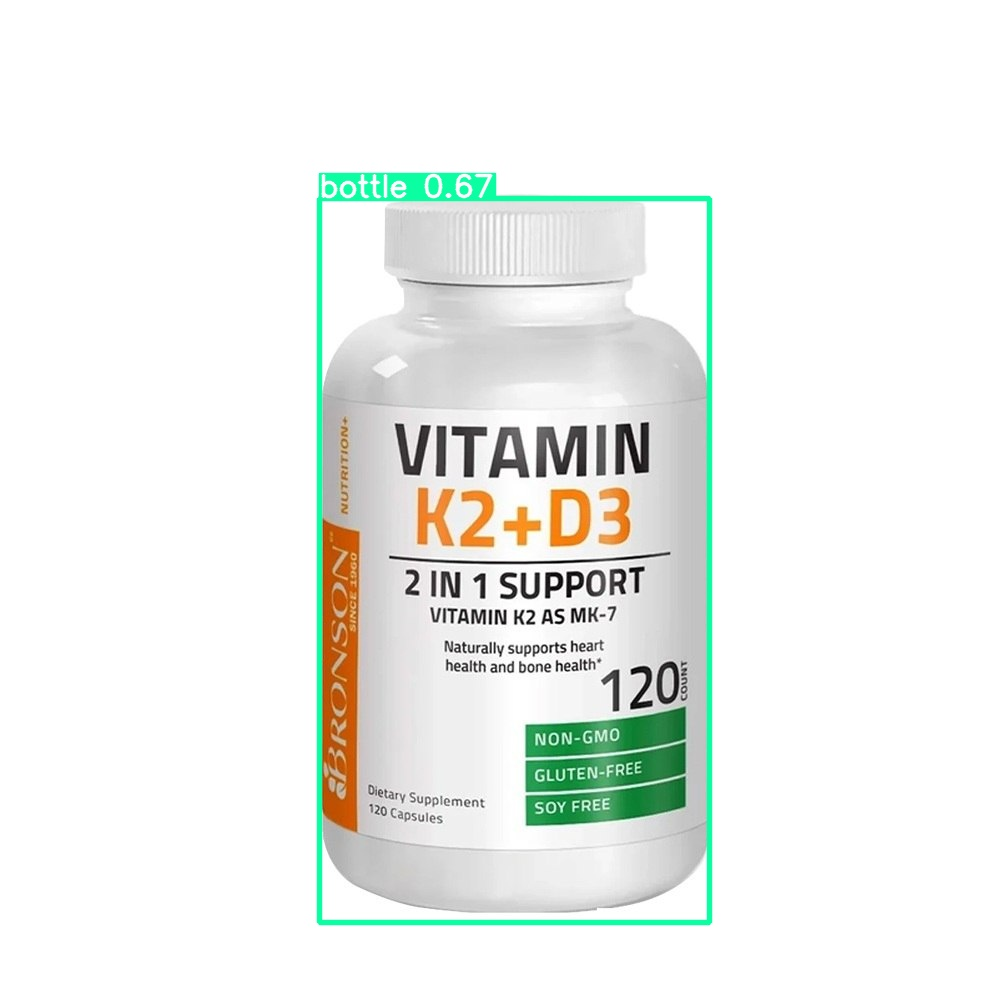

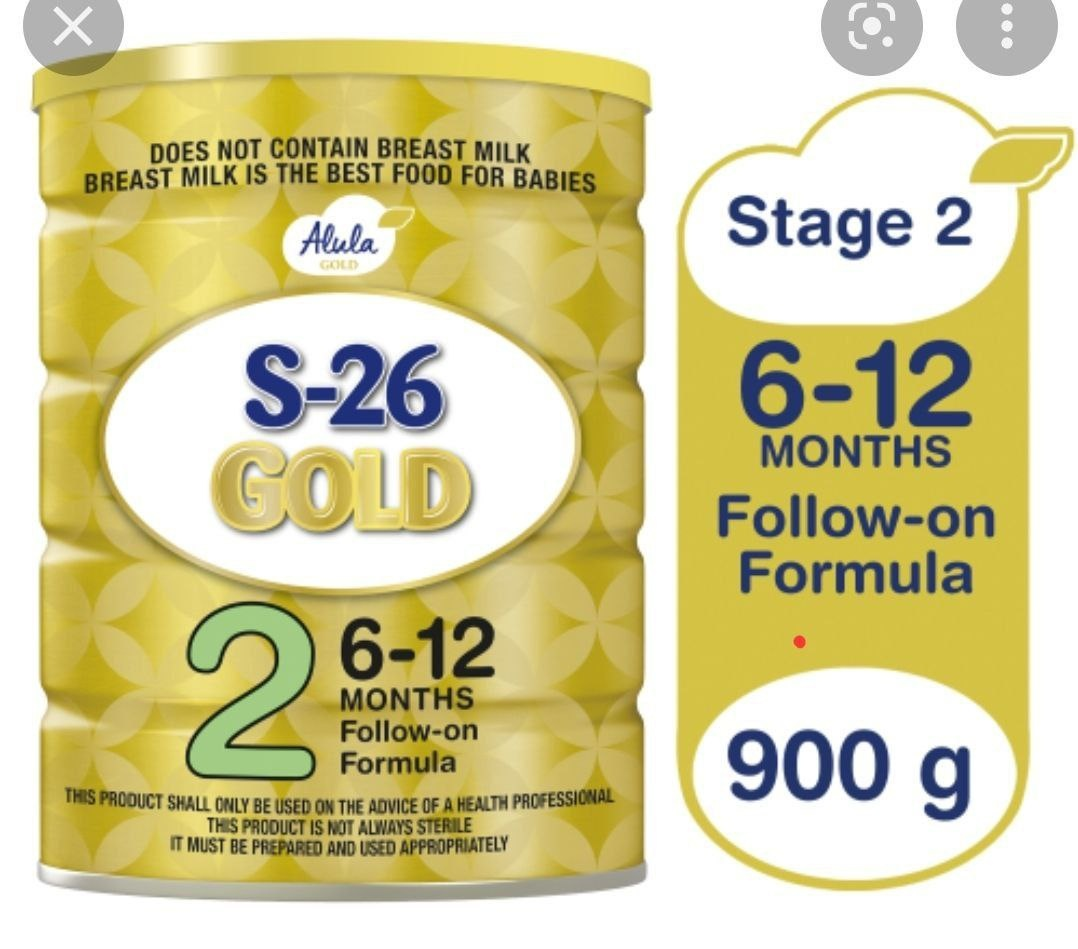

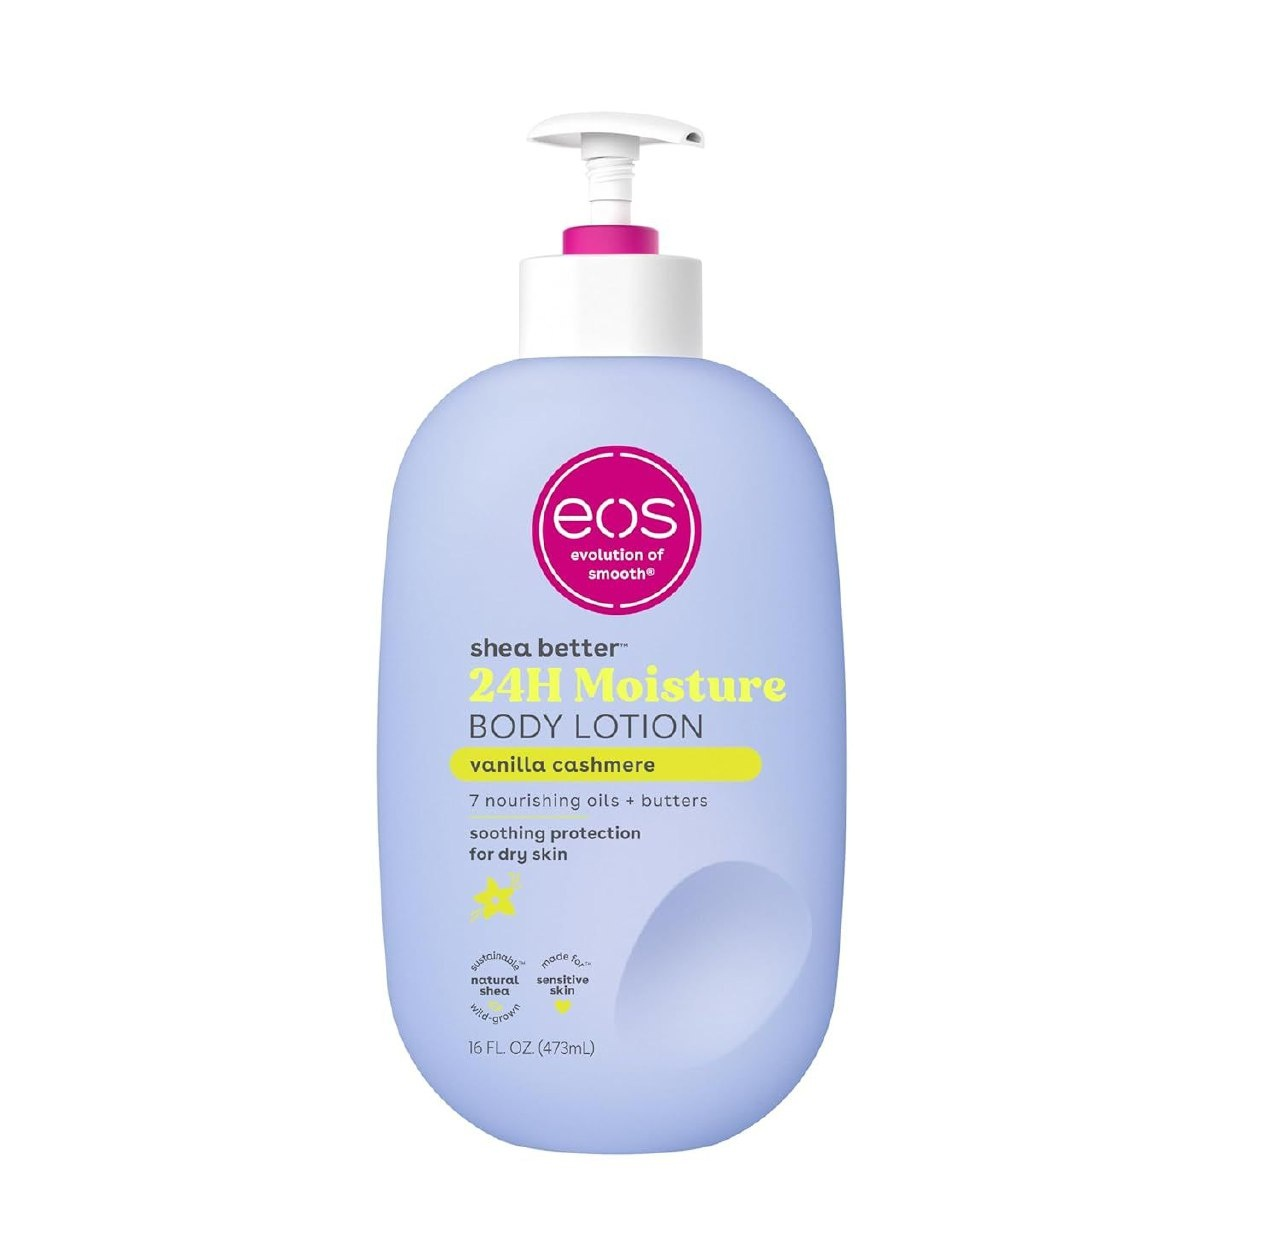

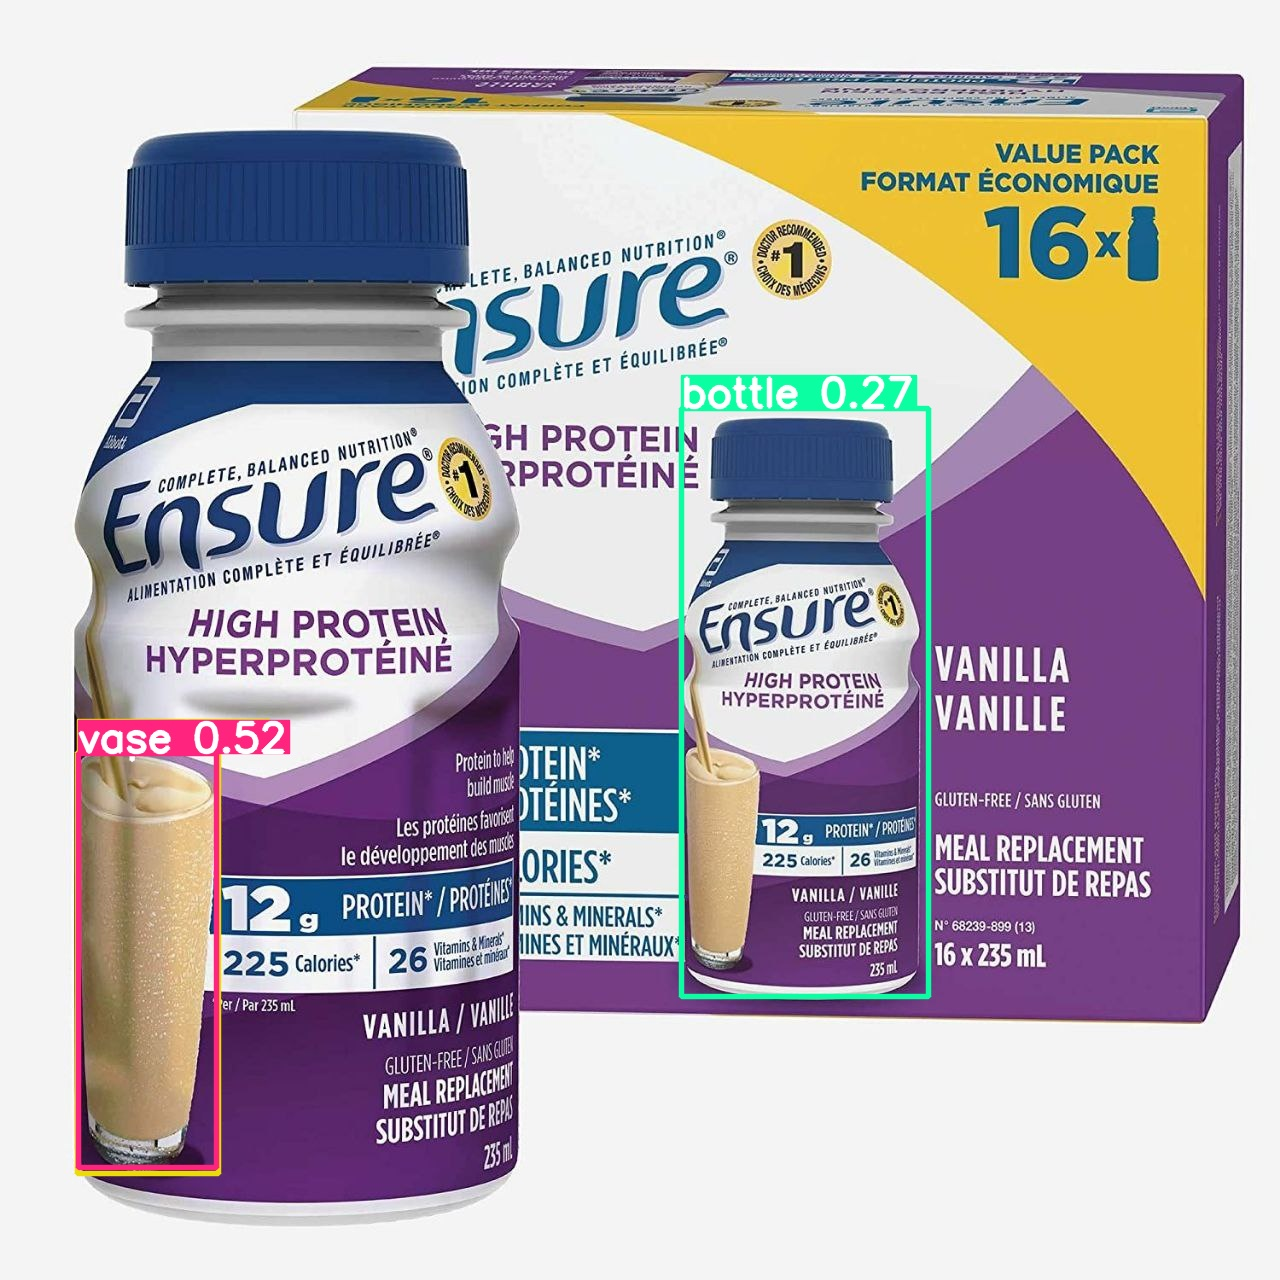

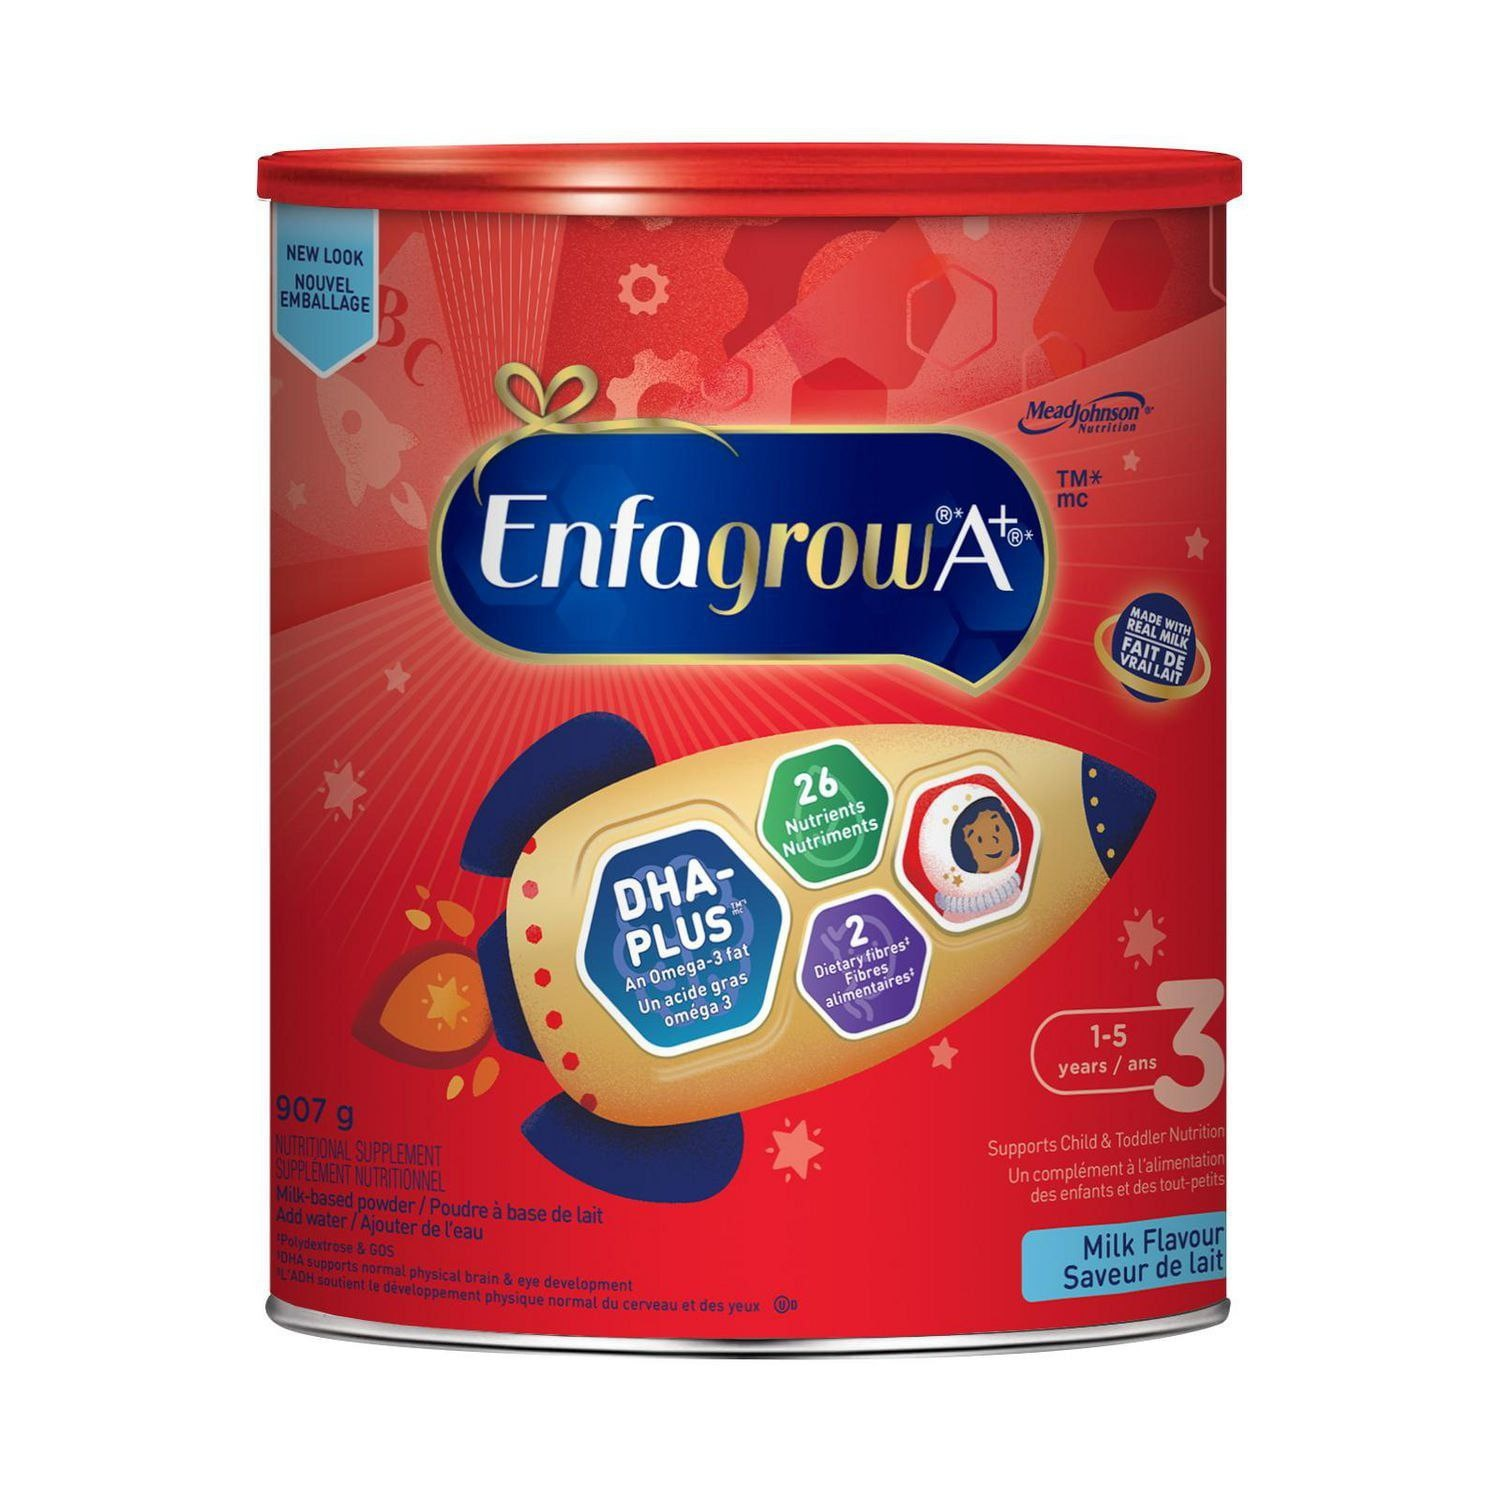

In [36]:
# Import the required modules
from IPython.display import Image, display
import os
import pandas as pd

# Define the save directory and CSV file path
save_dir = 'detection_results'
csv_file = 'detection_results.csv'

# Check the contents of the save directory
if os.path.exists(save_dir):
    files = os.listdir(save_dir)
    print("Files in save directory:", files)
else:
    print("Save directory not found")

# Check the contents of the CSV file
if os.path.exists(csv_file):
    df = pd.read_csv(csv_file)
    print("CSV file contents:")
    print(df.head())
else:
    print("CSV file not found or is empty")

# Display the first few annotated images
if os.path.exists(save_dir):
    files = os.listdir(save_dir)
    for filename in files[:5]:  # Display the first 5 images
        if filename.endswith(".jpg"):
            display(Image(os.path.join(save_dir, filename)))
else:
    print("Save directory not found")


Zip the Folder

In [39]:
import shutil

# Define the folder you want to zip
folder_to_zip = 'photo_results'
# Define the name of the zip file
zip_file = 'photo_results.zip'

# Zip the folder
shutil.make_archive(zip_file.replace('.zip', ''), 'zip', folder_to_zip)


'/content/photo_results.zip'

Download the Zip File

In [40]:
from google.colab import files

# Download the zip file
files.download(zip_file)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>